In [1]:
## Notes
## * Rows are *not* deleted from `cx_translations` when the translation drafts are purged

In [4]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from wmfdata import charting, hive
from wmfdata.utils import pd_display_all, insert_code_toggle

insert_code_toggle()

In [5]:
charting.set_mpl_style()

def plot_df(df):
    ax = df.plot.area()
    ylim = plt.ylim()
    plt.ylim((ylim[0], ylim[1] * 1.1))

In [6]:
CHART_START = "2018-07"
MWH_SNAPSHOT = "2019-12" # The end of this month will also be the end of the charts
TARGET_WIKIS = ("mlwiki", "bnwiki", "tlwiki", "jvwiki", "mnwiki", "sqwiki")

time_range = pd.period_range(CHART_START, pd.Period(MWH_SNAPSHOT), freq="W-SUN")
time_end = time_range[-1].to_timestamp(how="end")

# If the last week goes past the end of mediawiki_history, remove it
if time_end > pd.Timestamp(MWH_SNAPSHOT):
    time_range = time_range[:-1]
    time_start = time_range[0].to_timestamp(how="start")
    time_end = (time_range[-1] + 1).to_timestamp(how="start")
    
query_params = {
    "MWH_SNAPSHOT": MWH_SNAPSHOT,
    "time_start": time_start,
    "time_end": time_end
}

In [8]:
translations = hive.run("""
select
    wiki_db as wiki,
    date_format(event_timestamp, "yyyy-MM-dd") as date,
    event_user_text as translator,
    if(revision_is_deleted_by_page_deletion, "deleted", "surviving") as current_status,
    if(array_contains(revision_tags, "contenttranslation-v2"), 2, 1) as cx_version
from wmf.mediawiki_history mh
left join event_sanitized.serversideaccountcreation ssac
on
    ssac.event.username = event_user_text and
    ssac.year >= 0
where
    mh.snapshot = "{MWH_SNAPSHOT}" and
    mh.event_timestamp between "{time_start}" and "{time_end}" and
    event_entity = "revision" and
    event_type = "create" and
    array_contains(revision_tags, "contenttranslation")
""".format(**query_params)
).assign(
    date=lambda df: pd.to_datetime(df["date"])
).assign(
    week=lambda df: df["date"].dt.to_period("W-SUN").dt.to_timestamp()
)

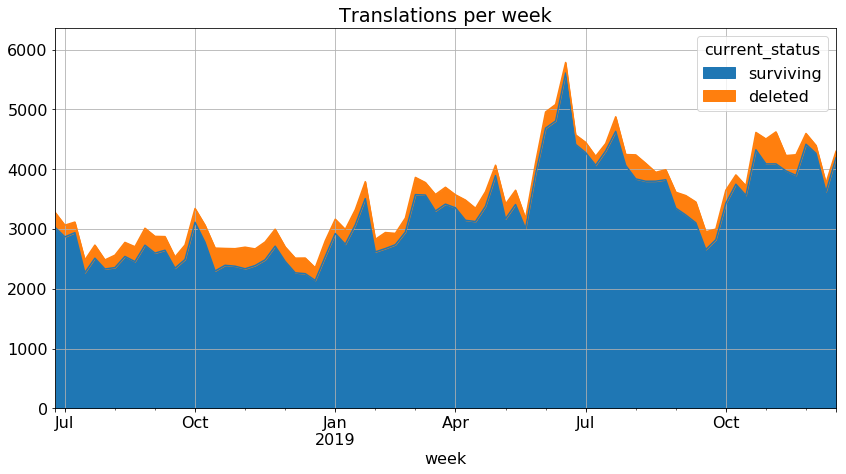

In [9]:
weekly_translations = translations.groupby(["week", "current_status"]).size().unstack()[["surviving", "deleted"]]

plot_df(weekly_translations)
plt.title("Translations per week");

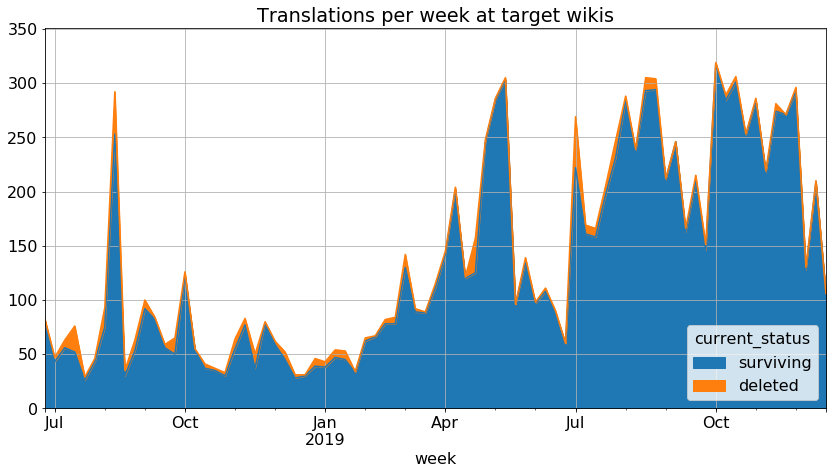

In [10]:
weekly_target_wiki_translations = (
    translations
    .query("wiki in @TARGET_WIKIS")
    .groupby(["week", "current_status"])
    .size()
    .unstack()
    [["surviving", "deleted"]]
)

plot_df(weekly_target_wiki_translations)
plt.title("Translations per week at target wikis");

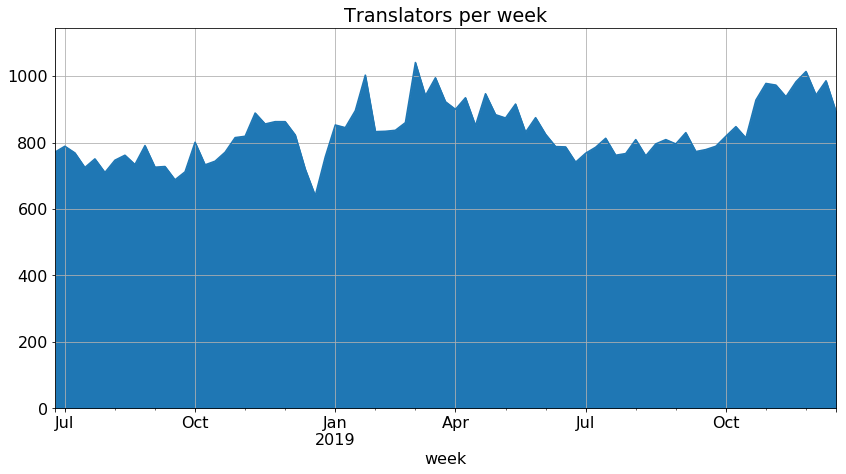

In [11]:
weekly_translators = (
    translations
    .groupby("week")
    .nunique()["translator"]
)

plot_df(weekly_translators)
plt.title("Translators per week");

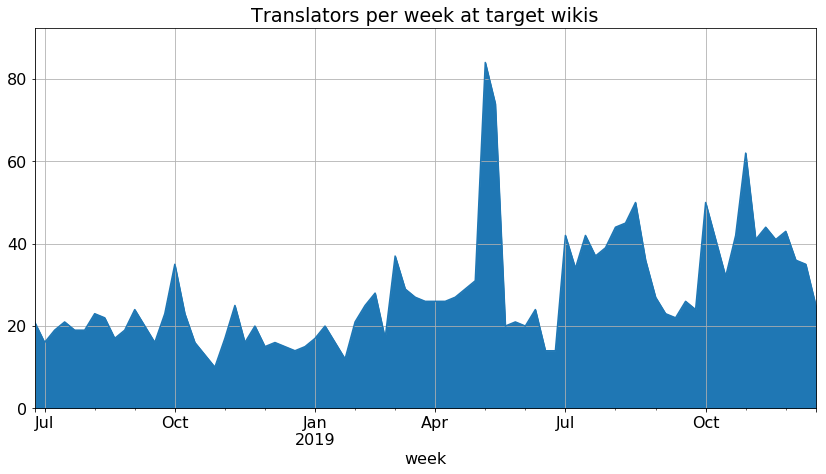

In [13]:
weekly_target_wiki_translators = (
    translations
    .query("wiki in @TARGET_WIKIS")
    .groupby("week")
    .nunique()["translator"]
)

plot_df(weekly_target_wiki_translators)
plt.title("Translators per week at target wikis");

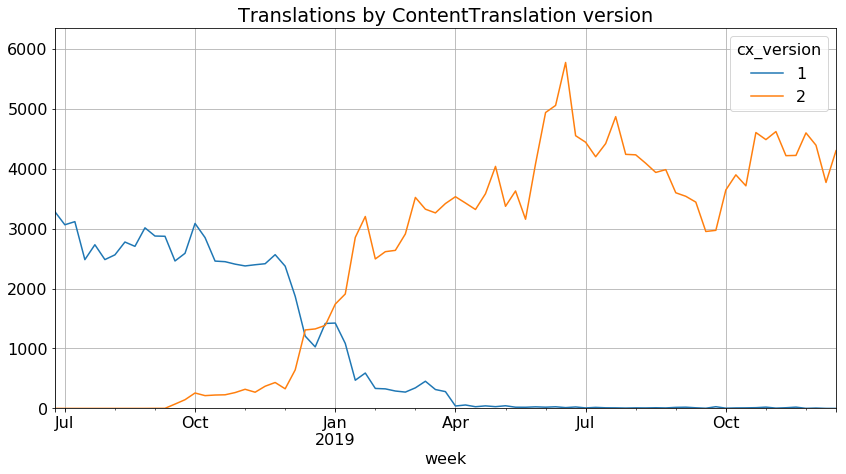

In [14]:
translations_by_version = translations.groupby(["week", "cx_version"]).size().unstack().fillna(0)
translations_by_version.plot()
ylim = plt.ylim()
plt.ylim((0, ylim[1] * 1.1))
plt.title("Translations by ContentTranslation version");

In [15]:
(
    translations_by_version
    .set_index(translations_by_version.index.strftime("%Y-%m-%d"))
    .rename_axis("week")
    .tail()
    .style.format("{:.0f}")
)

cx_version,1,2
week,,
2019-11-25,21,4221
2019-12-02,1,4597
2019-12-09,6,4391
2019-12-16,0,3770
2019-12-23,0,4300


In [16]:
now = pd.Timestamp.utcnow()
now_date = now.strftime("%Y-%m-%d")
now_time = now.strftime("%H:%M %Z")

print("This dashboard was generated on {} at {}.".format(now_date, now_time))

This dashboard was generated on 2020-01-20 at 17:01 UTC.
